# Trip Duration Questions
- which month
- see whcich days has the most duration
- rush hour
- week ends
- distance distribution
- relation between distance and trip duration
- duration outlier
- colors for charts
- numbers shoun in chart


## import libraries , import and prepare data

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [40]:
root_dir = r'C:\Users\ahmed\Downloads\1 project-nyc-taxi-trip-duration\1 project-nyc-taxi-trip-duration\Data'
train = pd.read_csv(os.path.join(root_dir, 'split/train.csv'))
test = pd.read_csv(os.path.join(root_dir, 'split/val.csv'))

In [41]:
from geopy.distance import geodesic

def geopy_distance(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
    coord1=(pickup_latitude,pickup_longitude)
    coord2=(dropoff_latitude, dropoff_longitude)
    return geodesic(coord1, coord2).kilometers
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

def prepare(df):
    df=df.drop(columns=['id','store_and_fwd_flag'])
    df['log_trip_duration'] = np.log1p(df.trip_duration)
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['dayofweek'] = df.pickup_datetime.dt.dayofweek
    df['month'] = df.pickup_datetime.dt.month
    df['hour'] = df.pickup_datetime.dt.hour
    df['dayofyear'] = df.pickup_datetime.dt.dayofyear
    df["distance_km"] = df.apply(
        lambda row: geopy_distance(
            row["pickup_latitude"],
            row["pickup_longitude"],
            row["dropoff_latitude"],
            row["dropoff_longitude"]
        ),
        axis=1
    )
    #df['distance_km']=np.log1p(df['distance_km'])
    df['distance_km_sqrt']=np.sqrt(df['distance_km'])
    df['distance_km_pw']=df['distance_km']**2


    df['is_weekend'] = df['dayofweek'].isin([5, 6])
    df['work_day']=~df['is_weekend']
    df['is_rush_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 9)) | ((df['hour'] >= 16) & (df['hour'] <= 19))
    return df
def remove_outliers(df):
    Q1 = df['log_trip_duration'].quantile(0.25)
    Q3 = df['log_trip_duration'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bond = 8.470511843477752
    lower_bond = 4.49601610236845
    df=df[df['log_trip_duration']>lower_bond]
    df = df[df['log_trip_duration'] < upper_bond]
    return df

In [42]:
df=prepare(train)
test=prepare(test)

## exploring data

In [43]:
df.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,log_trip_duration,dayofweek,month,hour,dayofyear,distance_km,distance_km_sqrt,distance_km_pw,is_weekend,work_day,is_rush_hour
0,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,1040,6.947937,2,6,7,160,2.759702,1.661235,7.615953,False,True,True
1,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,827,6.719013,6,4,12,94,1.959062,1.399665,3.837923,True,False,False
2,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,614,6.421622,6,6,2,157,1.407727,1.186477,1.981695,True,False,False
3,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,867,6.766192,3,5,17,126,1.976073,1.405729,3.904866,False,True,True
4,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,4967,8.510773,3,5,17,133,20.861805,4.567473,435.214911,False,True,True


In [44]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
vendor_id,1000000.0,1.534793,1.0,1.0,2.0,2.0,2.0,0.498788
pickup_datetime,1000000,2016-04-01 08:53:15.180106752,2016-01-01 00:00:53,2016-02-17 15:26:08,2016-04-01 15:01:29.500000,2016-05-15 02:35:38.750000128,2016-06-30 23:59:37,NaN
passenger_count,1000000.0,1.665353,0.0,1.0,1.0,2.0,7.0,1.315723
pickup_longitude,1000000.0,-73.973475,-121.933342,-73.991852,-73.981728,-73.967346,-61.335529,0.065404
pickup_latitude,1000000.0,40.750947,34.359695,40.737372,40.754131,40.768379,51.881084,0.033745
dropoff_longitude,1000000.0,-73.973421,-121.933304,-73.991341,-73.979767,-73.963036,-61.335529,0.065432
dropoff_latitude,1000000.0,40.751829,34.359695,40.735928,40.754551,40.769833,43.921028,0.035782
trip_duration,1000000.0,954.884971,1.0,397.0,662.0,1074.0,2227612.0,3882.070116
log_trip_duration,1000000.0,6.466492,0.693147,5.986452,6.496775,6.980076,14.616441,0.794744
dayofweek,1000000.0,3.051486,0.0,1.0,3.0,5.0,6.0,1.954644


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   vendor_id          1000000 non-null  int64         
 1   pickup_datetime    1000000 non-null  datetime64[ns]
 2   passenger_count    1000000 non-null  int64         
 3   pickup_longitude   1000000 non-null  float64       
 4   pickup_latitude    1000000 non-null  float64       
 5   dropoff_longitude  1000000 non-null  float64       
 6   dropoff_latitude   1000000 non-null  float64       
 7   trip_duration      1000000 non-null  int64         
 8   log_trip_duration  1000000 non-null  float64       
 9   dayofweek          1000000 non-null  int32         
 10  month              1000000 non-null  int32         
 11  hour               1000000 non-null  int32         
 12  dayofyear          1000000 non-null  int32         
 13  distance_km        1000000 n

notice that there may be outlier in trip duration we will investigate this later

## investigating column by column (univriate)

### investigating vendor

In [46]:
vendor_counts=df.value_counts(subset=['vendor_id']).reset_index()
vendor_counts

,vendor_id,count
0,2,534793
1,1,465207


In [47]:
vendor_df=df.groupby('vendor_id').median()

In [48]:
vendor_df

,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,log_trip_duration,dayofweek,month,hour,dayofyear,distance_km,distance_km_sqrt,distance_km_pw,is_weekend,work_day,is_rush_hour
vendor_id,,,,,,,,,,,,,,,,,,
1,2016-04-02 00:23:19,1.0,-73.981956,40.753742,-73.979897,40.754372,657.0,6.489205,3.0,4.0,14.0,93.0,2.083526,1.443442,4.341082,0.0,1.0,0.0
2,2016-04-01 00:56:31,1.0,-73.981522,40.754436,-73.979660,40.754700,666.0,6.502790,3.0,4.0,14.0,92.0,2.098846,1.448740,4.405155,0.0,1.0,0.0


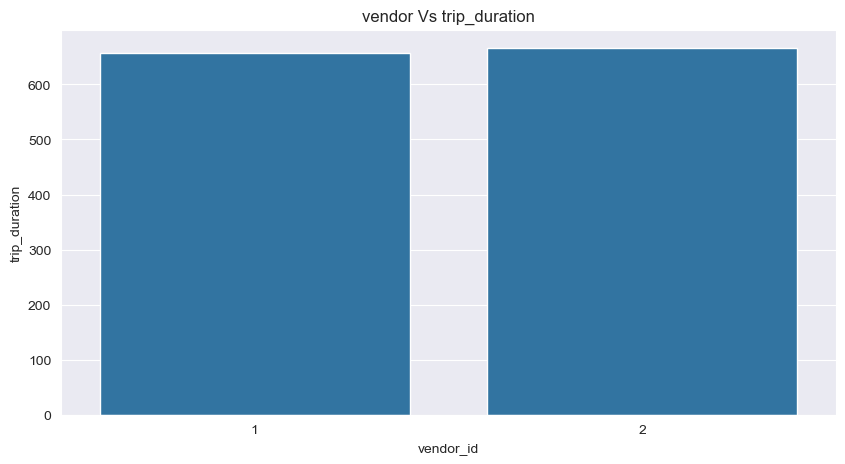

In [49]:
plt.figure(figsize=(10,5))
sns.barplot(vendor_df,x=vendor_df.index,y=vendor_df['trip_duration'])
plt.xlabel("vendor_id")
plt.ylabel("trip_duration")
plt.title("vendor Vs trip_duration")
plt.show()

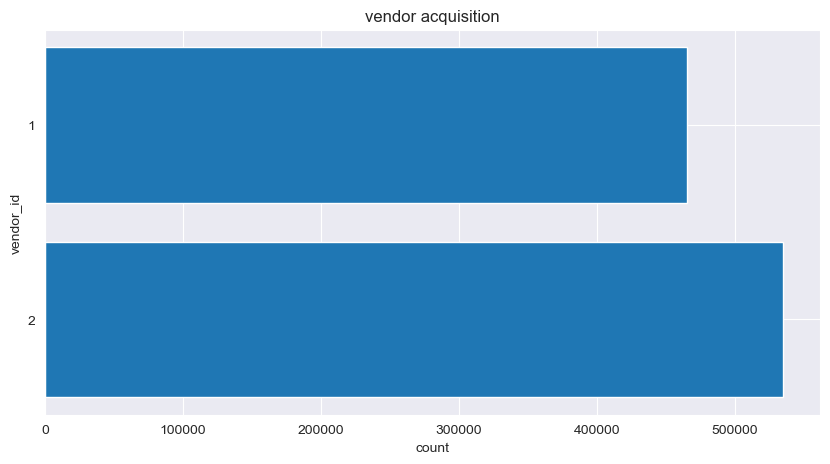

In [50]:
plt.figure(figsize=(10,5))
plt.barh(vendor_counts['vendor_id'].astype('str'),vendor_counts['count'])
plt.ylabel("vendor_id")
plt.xlabel("count")
plt.title("vendor acquisition")
plt.show()

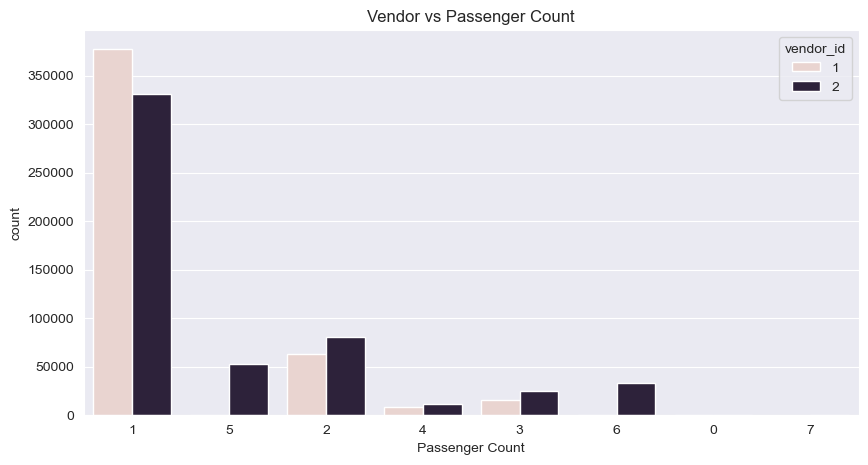

In [51]:
#move to multivariate
df['passenger_count_str'] = df['passenger_count'].astype(str)

plt.figure(figsize=(10,5))
sns.countplot(
    data=df,
    x='passenger_count_str',
    hue='vendor_id'
)
plt.xlabel("Passenger Count")
plt.ylabel("count")
plt.title("Vendor vs Passenger Count")
plt.show()

notice that vendor 2 carry more people in the trip

### investigating passenger count

In [52]:
passenger_counts=df.value_counts(subset=['passenger_count']).reset_index()
passenger_counts

,passenger_count,count
0,1,708628
1,2,143907
2,5,53635
3,3,41012
4,6,33287
5,4,19491
6,0,38
7,7,2


C:\Users\ahmed\AppData\Local\Temp\ipykernel_11880\4216861801.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Passenger Count")


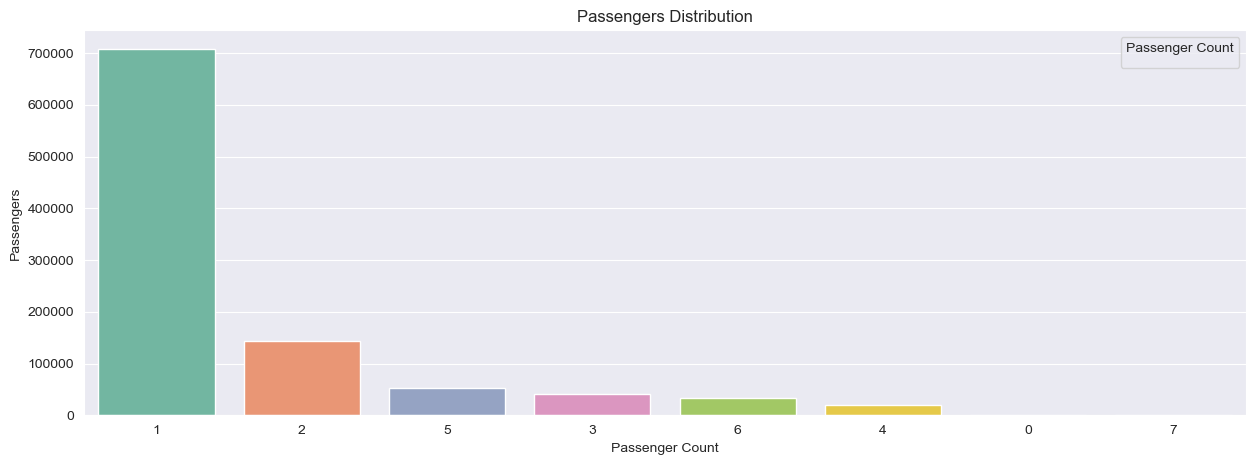

In [53]:
passenger_counts['passenger_count_str'] = passenger_counts['passenger_count'].astype(str)

plt.figure(figsize=(15,5))
sns.barplot(
    data=passenger_counts,
    x="passenger_count_str",   # use column name instead of Series
    y="count",
    hue="passenger_count_str", # assign hue for legend & colors
    palette="Set2"
)
plt.ylabel("Passengers")
plt.xlabel("Passenger Count")
plt.title("Passengers Distribution")
plt.legend(title="Passenger Count")
plt.show()

notice that more passengers less trips


### investigating trip duration

<Figure size 1000x500 with 0 Axes>

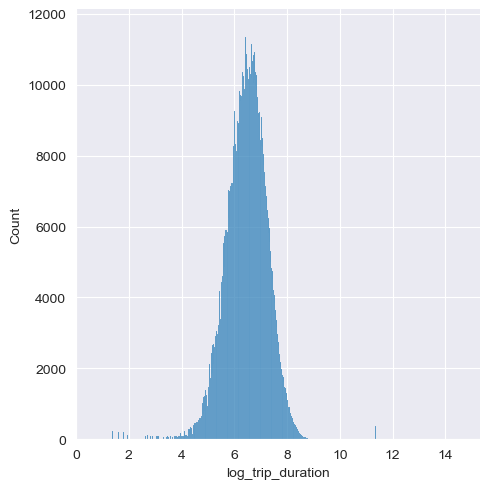

In [54]:
plt.figure(figsize=(10,5))
sns.displot(data=df,x=df['log_trip_duration'])
plt.show()

we notice that duration are normally distributed

<Axes: xlabel='log_trip_duration'>

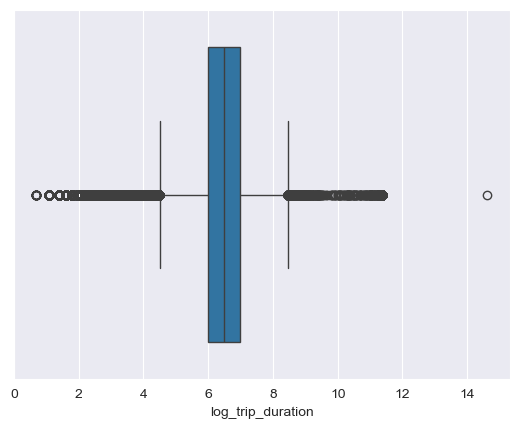

In [55]:
sns.boxplot(data=df,x='log_trip_duration')

notice outlires

#### investigating outlires

In [56]:
df['log_trip_duration'].describe()

count    1000000.000000
mean           6.466492
std            0.794744
min            0.693147
25%            5.986452
50%            6.496775
75%            6.980076
max           14.616441
Name: log_trip_duration, dtype: float64

In [57]:
Q1=df['log_trip_duration'].quantile(0.25)
Q3=df['log_trip_duration'].quantile(0.75)
IQR=Q3-Q1
upper_bond=Q3+IQR*1.5
lower_bond=Q1-IQR*1.5
print(f'lower > {lower_bond} , upper > {upper_bond}')

lower > 4.49601610236845 , upper > 8.470511843477752


In [58]:
df[df['log_trip_duration']<lower_bond]

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,log_trip_duration,dayofweek,month,hour,dayofyear,distance_km,distance_km_sqrt,distance_km_pw,is_weekend,work_day,is_rush_hour,passenger_count_str
63,2,2016-05-07 21:55:11,1,-73.988792,40.731113,-73.988853,40.730991,26,3.295837,5,5,21,128,0.014503,0.120429,2.103429e-04,True,False,False,1
337,1,2016-03-10 04:08:10,1,-73.954857,40.688107,-73.954865,40.688107,16,2.833213,3,3,4,70,0.000645,0.025395,4.159177e-07,False,True,False,1
357,1,2016-04-23 19:31:22,1,-73.993027,40.723320,-73.993027,40.723316,11,2.484907,5,4,19,114,0.000424,0.020582,1.794511e-07,True,False,True,1
465,2,2016-06-02 14:09:31,2,-74.007187,40.728519,-74.006500,40.732330,83,4.430817,3,6,14,154,0.427150,0.653567,1.824575e-01,False,True,False,2
703,2,2016-05-21 01:50:55,2,-73.973633,40.787182,-73.973633,40.787182,14,2.708050,5,5,1,142,0.000000,0.000000,0.000000e+00,True,False,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999722,2,2016-02-15 09:15:37,1,-73.976074,40.756966,-73.973701,40.760399,60,4.110874,0,2,9,46,0.430697,0.656275,1.855002e-01,False,True,True,1
999732,2,2016-02-13 20:48:37,2,-73.965698,40.754498,-73.963943,40.756718,82,4.418841,5,2,20,44,0.287650,0.536330,8.274270e-02,True,False,False,2
999854,1,2016-04-24 02:03:06,1,-74.006706,40.741665,-74.003830,40.748196,82,4.418841,6,4,2,115,0.764839,0.874551,5.849785e-01,True,False,False,1
999857,2,2016-04-14 20:32:28,1,-73.969940,40.764549,-73.970329,40.764702,34,3.555348,3,4,20,105,0.036966,0.192264,1.366453e-03,False,True,False,1


In [59]:
df[df['log_trip_duration']>upper_bond]

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,log_trip_duration,dayofweek,month,hour,dayofyear,distance_km,distance_km_sqrt,distance_km_pw,is_weekend,work_day,is_rush_hour,passenger_count_str
4,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,4967,8.510773,3,5,17,133,20.861805,4.567473,435.214911,False,True,True,4
16,2,2016-05-16 16:24:41,1,-73.966660,40.762978,-73.790512,40.644077,4946,8.506537,0,5,16,137,19.898278,4.460749,395.941467,False,True,True,1
196,2,2016-02-10 09:03:24,1,-73.982475,40.763000,-73.808678,40.688858,5584,8.627840,2,2,9,41,16.833788,4.102900,283.376422,False,True,True,1
605,2,2016-02-22 09:06:37,1,-73.955414,40.779453,-73.963234,40.809166,86358,11.366268,0,2,9,53,3.364950,1.834380,11.322885,False,True,True,1
846,2,2016-06-16 16:11:20,2,-74.008072,40.723080,-73.788849,40.641529,6485,8.777401,3,6,16,168,20.626924,4.541687,425.470000,False,True,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998343,2,2016-01-10 21:44:47,5,-73.991882,40.744041,-73.955719,40.776272,86318,11.365805,6,1,21,10,4.704777,2.169050,22.134926,True,False,False,5
998664,2,2016-05-15 09:50:34,1,-74.010139,40.712032,-73.998161,40.677639,86270,11.365249,6,5,9,136,3.951216,1.987767,15.612109,True,False,True,1
999349,1,2016-03-22 14:37:14,3,-73.797539,40.644897,-74.034828,40.722885,5999,8.699515,1,3,14,82,21.849110,4.674303,477.383590,False,True,False,3
999403,2,2016-04-12 14:12:11,5,-73.983017,40.750317,-73.983566,40.748009,86289,11.365469,1,4,14,103,0.260454,0.510347,0.067836,False,True,False,5


notice that there is trips less than ***tow min*** and there is trips over ***20 h***
like ***what is that!!!*** taxi usually takes from ***5 to 30*** minute
We have two ways
   1. Small values less than 1.5 min this could be outlires and other may be a lezzy person
   2. bigger values will see the Date maybe something happen in that period of time
   3. delete them they are small counts


***searching for dates

Removing outliers

In [60]:
df=remove_outliers(df)


### investigating days

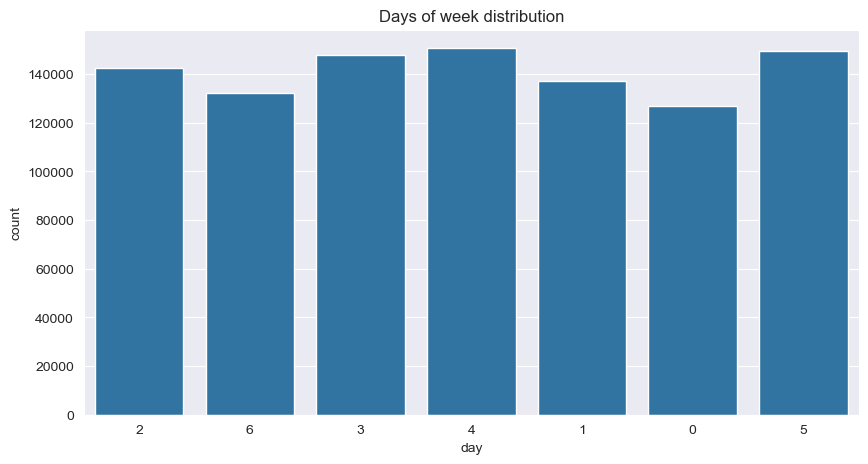

In [61]:
#move to multivariate
df['dayofweek_str'] = df['dayofweek'].astype(str)
plt.figure(figsize=(10,5))
sns.countplot(
    data=df,
    x='dayofweek_str',
)
plt.xlabel("day")
plt.ylabel("count")
plt.title("Days of week distribution")
plt.show()

it seems like its normal all days work

In [62]:
days_df=df.groupby('dayofweek_str')[['log_trip_duration','trip_duration']].median().reset_index()
days_df

,dayofweek_str,log_trip_duration,trip_duration
0,0,6.453625,634.0
1,1,6.527958,683.0
2,2,6.549651,698.0
3,3,6.569481,712.0
4,4,6.541030,692.0
5,5,6.461468,639.0
6,6,6.411818,608.0


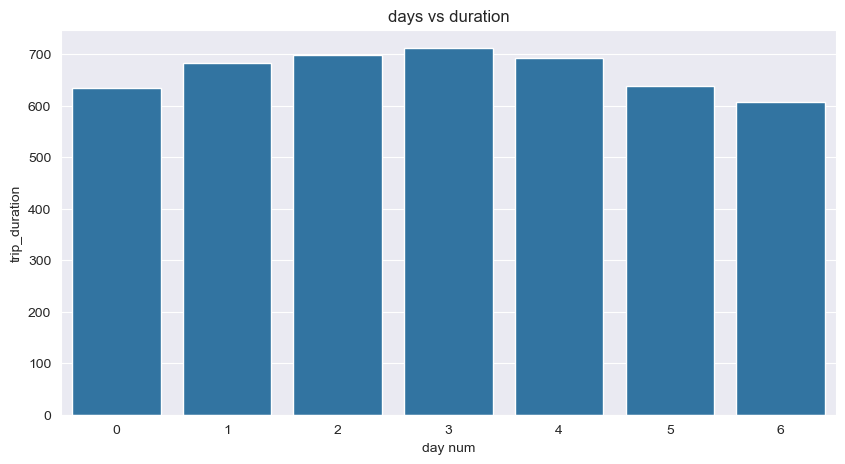

In [63]:
plt.figure(figsize=(10,5))
sns.barplot(days_df,x=days_df['dayofweek_str'],y=days_df['trip_duration'])
plt.xlabel("day num")

plt.ylabel("trip_duration")
plt.title("days vs duration")
plt.show()

nothing special

### investigating monhts


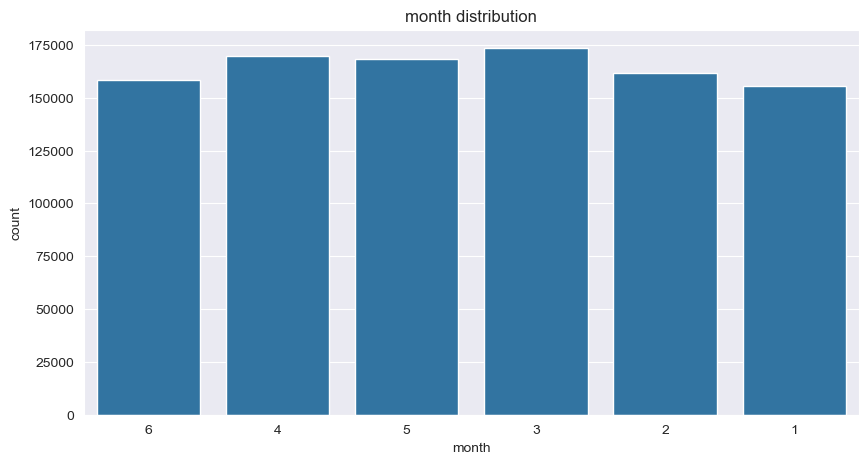

In [64]:
#move to multivariate
df['month_str'] = df['month'].astype(str)
plt.figure(figsize=(10,5))
sns.countplot(
    data=df,
    x='month_str',
)
plt.xlabel("month")
plt.ylabel("count")
plt.title("month distribution")
plt.show()

In [65]:
months_df=df.groupby('month_str')[['log_trip_duration','trip_duration']].median().reset_index()
months_df

,month_str,log_trip_duration,trip_duration
0,1,6.452049,633.0
1,2,6.464588,641.0
2,3,6.489205,657.0
3,4,6.522093,679.0
4,5,6.542472,693.0
5,6,6.549651,698.0


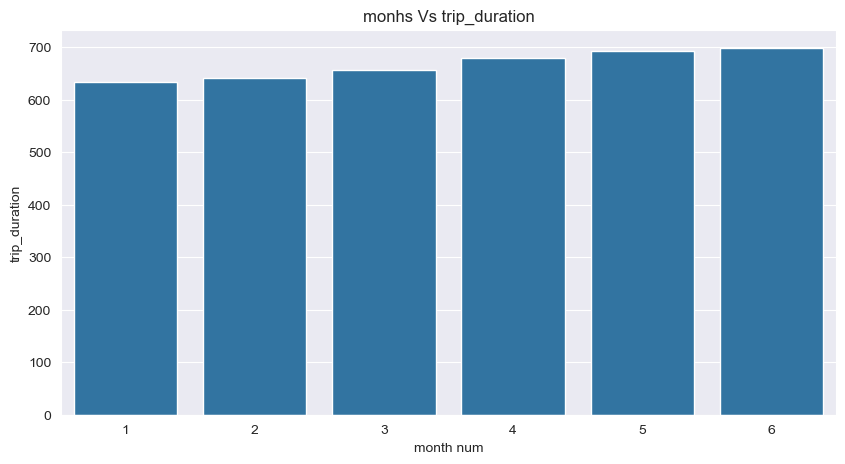

In [66]:
plt.figure(figsize=(10,5))
sns.barplot(months_df,x=months_df['month_str'],y=months_df['trip_duration'])
plt.xlabel("month num")

plt.ylabel("trip_duration")
plt.title("monhs Vs trip_duration")
plt.show()

Nothing special

### investigating hours

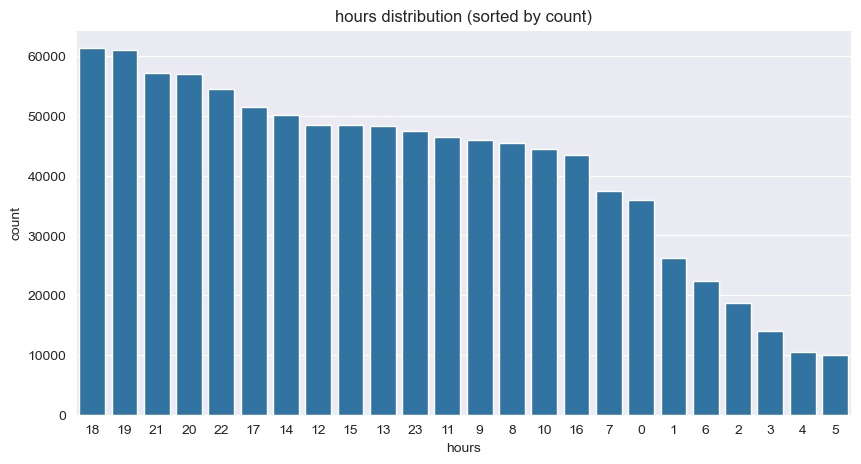

In [67]:
# move to multivariate
df['hour_str'] = df['hour'].astype(str)

# compute counts and sort by count
order = df['hour_str'].value_counts().sort_values(ascending=False).index

plt.figure(figsize=(10,5))
sns.countplot(
    data=df,
    x='hour_str',
    order=order
)

plt.xlabel("hours")
plt.ylabel("count")
plt.title("hours distribution (sorted by count)")
plt.show()


In [68]:
hour_df=df.groupby('hour_str')[['log_trip_duration','trip_duration']].sum().reset_index()
hour_df=hour_df.sort_values(by='trip_duration')
hour_df

,hour_str,log_trip_duration,trip_duration
19,5,62946.807127,7279618
18,4,67406.582655,7884592
17,3,89427.980613,10052913
12,2,119334.587905,13342977
20,6,139377.587700,15073731
1,1,167901.982653,19515486
21,7,238174.589608,27820617
0,0,231357.229116,28266965
2,10,288888.094341,37710408
22,8,294445.300804,37729111


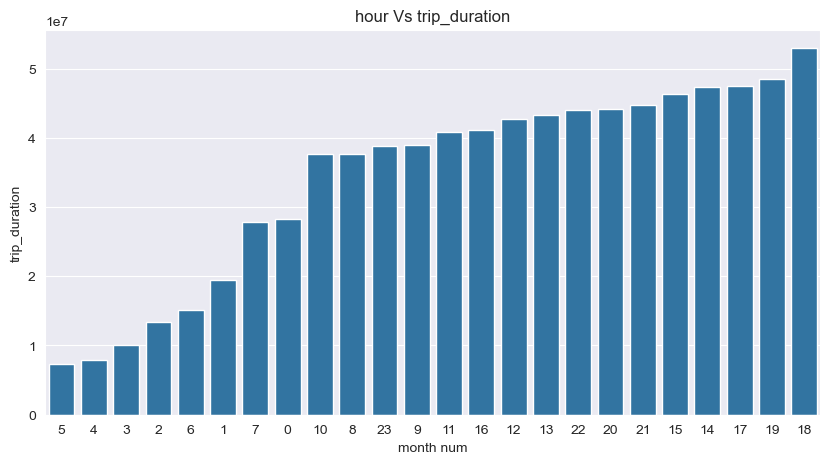

In [69]:
plt.figure(figsize=(10,5))
sns.barplot(hour_df,x=hour_df['hour_str'],y=hour_df['trip_duration'])
plt.xlabel("month num")

plt.ylabel("trip_duration")
plt.title("hour Vs trip_duration")
plt.show()

### investigating distance

In [70]:
df['distance_km'].describe()

count    986773.000000
mean          3.448509
std           4.376970
min           0.000000
25%           1.253590
50%           2.110876
75%           3.888506
max        1240.510256
Name: distance_km, dtype: float64

<Axes: >

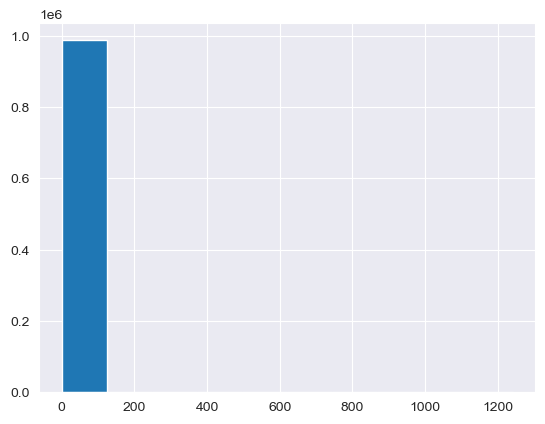

In [71]:
df['distance_km'].hist()

<Axes: >

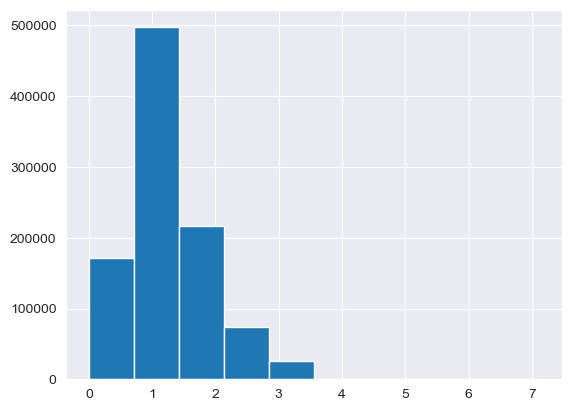

In [72]:
np.log1p(df['distance_km']).hist()

In [79]:
df=df[df['distance_km']>0]
df = df[~((df['distance_km'] < 0.2) & (df['log_trip_duration'] > 5))]

<Axes: xlabel='distance_km', ylabel='log_trip_duration'>

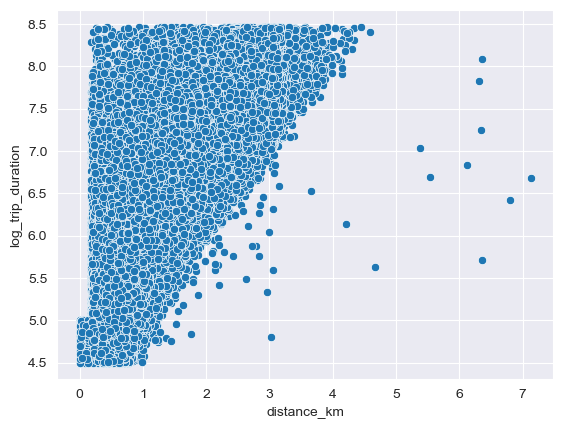

In [80]:
sns.scatterplot(df,x=np.log1p(df['distance_km']),y='log_trip_duration')

In [75]:
numeric_features = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
min_max=['distance_km','pickup_center_dist','dropoff_center_dist','distance_km_sqrt']
categorical_features = ['passenger_count','vendor_id','dayofweek', 'month', 'hour','is_weekend','is_rush_hour','dayofyear']

train_features = categorical_features + numeric_features + min_max

<Axes: >

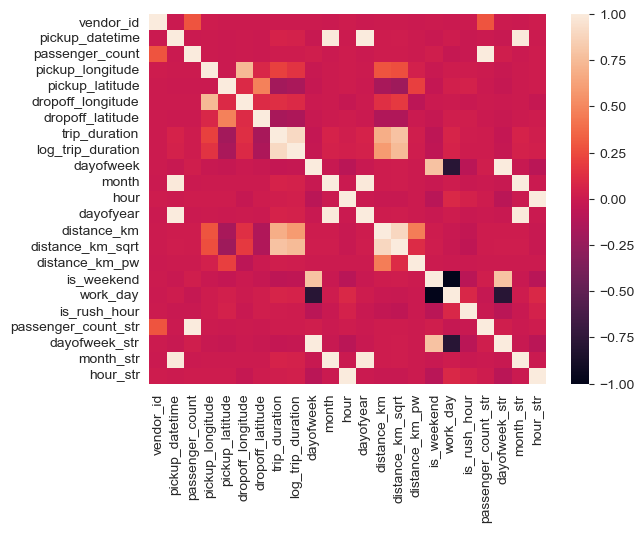

In [76]:
sns.heatmap(df.corr())
